## SUPPORTING CODE

[1. Import and clean data](#section1)<br/>
[2. Create new features](#section2)<br/>
[3. Explore revised dataframe](#section3)<br/>
    - [3a) Correlation heatmap](#section3a)<br/>
    - [3b) Analysis of post-purchase changes](#section3b)<br/>
    - [3c) Outlier analysis and treatment](#section3c)<br/>
[4. Final dataset for Regression](#section4)<br/>
[5. Addressing Endogeneity in Demand Model](#section5)<br/>
    -[5a) Structural Model OLS](#section5a)<br/>
    -[5b) Reduced Form Model for Price](#section5b)<br/>
    -[5c) 2SLS of Structural Model](#section5c)<br/>
    -[5d) Hausman Test for endogeneity](#section5d)<br/>
    -[5e) Sargan Test for overidentification](#section5e)<br/>
[6. Final 2SLS Demand Model](#section6)<br/>

### 1. IMPORT AND CLEAN DATA <a id="section1"></a>

In [ ]:
import pandas as pd
import datetime as dt
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import statsmodels.api as sm
from linearmodels.iv import IV2SLS
from linearmodels.iv import compare
from linearmodels.iv import results

from scipy.stats import chi2


df=pd.read_csv('Data-GP1.csv')

# Clean headers

df.columns=[x.strip().lower() for x in df.columns]
df.rename(columns={'culmulative_sales':'cumulative_sales'},inplace=True)


### 2. CREATE NEW FEATURES <a id="section2"></a>

In [ ]:
# Clean date columns

df.dept_date=pd.to_datetime(df['dept_date'])
df.purchase_date=pd.to_datetime(df['purchase_date'])

# Derive date features

df['dept_daynum']=(df.dept_date).dt.weekday+1
df['buy_lead_time']=df['dept_date']-df['purchase_date']
df['buy_lead_time']=df['buy_lead_time'].astype('timedelta64[D]')
df['dept_monthnum']=(df.dept_date).dt.month


In [ ]:
# Roughly check train utilization

train_count= df['train_number_all'].value_counts()
print('Train Utilization (in total bookings/n)')

# Check train operations/period and plot against df

train= df.groupby(by=['dept_date'])['train_number_all'].nunique().reset_index()
df=pd.merge(df,train,on='dept_date',how='inner')
df=df.rename(columns={'train_number_all_x':'train','train_number_all_y':'train_capacity'})

# Exclude O train data

filt=(df['train']!='O')
df=df[filt]


Train Utilization (in total bookings/n)


In [ ]:
# Resort dataset s.t. grouped by train, dept_date, customer type, cabin booked and gap from purchase to travel

df=df.sort_values(by=['train','dept_date','customer_cat','isnormcabin','buy_lead_time'],
                 ascending=[True,True,True,True,False])
df.head()


,num_seats_total,mean_net_ticket_price,dept_date,purchase_date,train,cumulative_sales,isnormcabin,isreturn,isoneway,customer_cat,dept_daynum,buy_lead_time,dept_monthnum,train_capacity
202522,1,418.084961,2018-06-01,2018-06-01,A,1,0,0,0,A,5,0.0,6,6
202514,1,464.041601,2018-06-02,2018-06-01,A,1,0,0,0,B,6,1.0,6,9
202492,4,561.181241,2018-06-03,2018-06-01,A,4,0,0,0,A,7,2.0,6,11
202495,1,633.715657,2018-06-03,2018-06-02,A,5,0,0,0,A,7,1.0,6,11
202505,2,763.550821,2018-06-03,2018-06-03,A,2,0,0,1,B,7,0.0,6,11


### 3. EXPLORE DATASET <a id="section3"></a>

#### 3A. Correlation Heatmap <a id="section3a"></a>

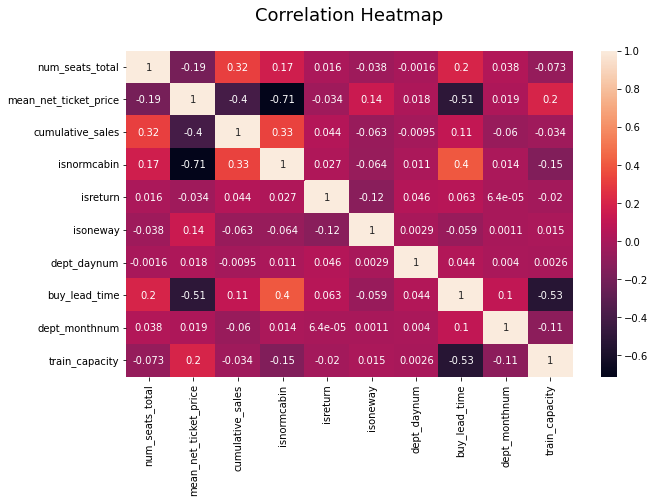

In [ ]:
plt.figure(figsize=(10, 6))
heatmap=sns.heatmap(df.corr(),annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=30)
plt.show()


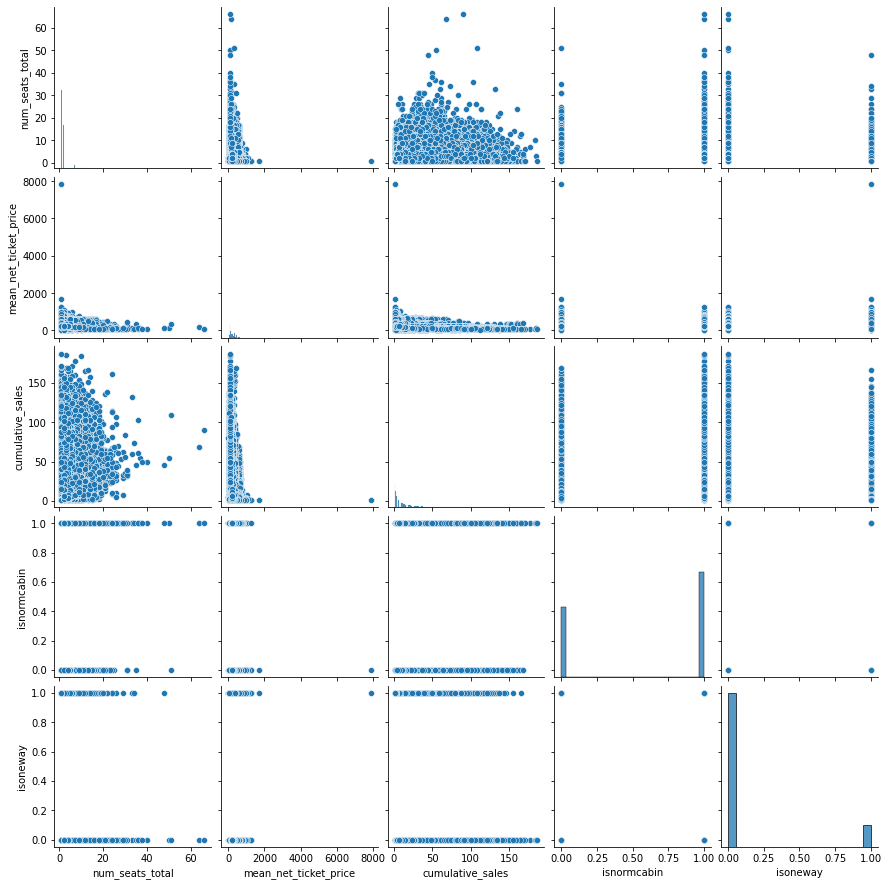

In [ ]:
# Plotting a comparative pairplot of the relevant features
import seaborn as sns
sns.pairplot(df[["num_seats_total", "mean_net_ticket_price", "train", "cumulative_sales", 
                 "isnormcabin", "isoneway", "customer_cat"]], markers = ['o'], height = 2.5)
plt.show()

In [ ]:
cat_cols=['train', 'isnormcabin', 'isreturn','isoneway', 'customer_cat', 'dept_daynum']
for i in cat_cols:
    print('{} Table'.format(i.upper()))
    print(df[i].value_counts(),'\n')

TRAIN Table
B    26855
E    26297
G    23030
H    19306
F    18557
I    17836
C    14612
D    13235
J    13016
A    12019
M     9583
K     6904
L     6010
N     2436
Name: train, dtype: int64 

ISNORMCABIN Table
1    125451
0     84245
Name: isnormcabin, dtype: int64 

ISRETURN Table
0    109004
1    100692
Name: isreturn, dtype: int64 

ISONEWAY Table
0    183930
1     25766
Name: isoneway, dtype: int64 

CUSTOMER_CAT Table
B    162403
A     47293
Name: customer_cat, dtype: int64 

DEPT_DAYNUM Table
5    32380
7    31513
4    30504
3    30409
1    28937
2    28887
6    27066
Name: dept_daynum, dtype: int64 



#### 3B. Analysis of Post-Purchase Changes <a id="section3b"></a>

In [ ]:
# Find the gross sales before cancellations/changes

df_gross_seats = df.groupby(['dept_date','train','isnormcabin', 'isreturn','isoneway', 
                     'customer_cat'])['num_seats_total'].sum().reset_index().rename(columns={'num_seats_total':
                                                                                             'gross_seats_sold'})

# Find the last date where a ticket was purchased for that combination

df_max_date = df.groupby(['dept_date', 'train', 'isnormcabin', 'isreturn','isoneway', 
                     'customer_cat'])['purchase_date'].max().reset_index().rename(columns={'purchase_date':
                                                                                           'last_purchase_date'})

# Merge everything back into a consolidated df_change

df_change = pd.merge(df, df_gross_seats, on = ['dept_date', 'train', 'isnormcabin', 'isreturn',
                                                 'isoneway', 'customer_cat'])

df_change = pd.merge(df_change, df_max_date, on = ['dept_date', 'train', 'isnormcabin', 'isreturn',
                                                 'isoneway', 'customer_cat'])

# Calculate the changes taking culmulative_sales - recalculated running total of seats sold (gross_seats_sold)

df_change.loc[df_change['last_purchase_date'] == df_change['purchase_date'],
              'increase/(decrease)'] = df_change['cumulative_sales']- df_change['gross_seats_sold']

df_change['increase/(decrease)'] = df_change['increase/(decrease)'].replace(np.nan, 0)

# Aggregate changes to a higher level by train (train_chg)

train_chg = df_change.groupby(['train'])['num_seats_total',
                                         'increase/(decrease)'].sum().reset_index().rename(columns={'num_seats_total':
                                                                                                    'gross_seats_sold'})

train_chg['increase/(decrease)%'] = round((train_chg['increase/(decrease)']/
                                           train_chg['gross_seats_sold'])*100,1).astype(str) + '%'

train_chg

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


,train,gross_seats_sold,increase/(decrease),increase/(decrease)%
0,A,24709,-1484.0,-6.0%
1,B,74539,7826.0,10.5%
2,C,30229,3237.0,10.7%
3,D,28363,-1752.0,-6.2%
4,E,73723,2553.0,3.5%
5,F,46310,536.0,1.2%
6,G,59059,6970.0,11.8%
7,H,50366,614.0,1.2%
8,I,41057,-582.0,-1.4%
9,J,27484,-2777.0,-10.1%


#### 3C. OUTLIER ANALYSIS AND TREATMENT <a id="section3c"></a>

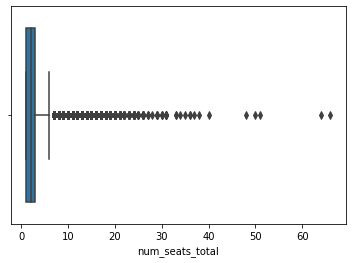

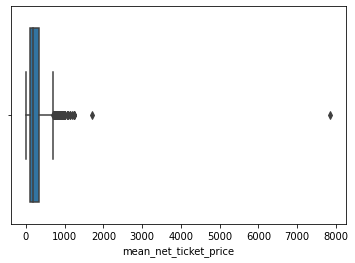

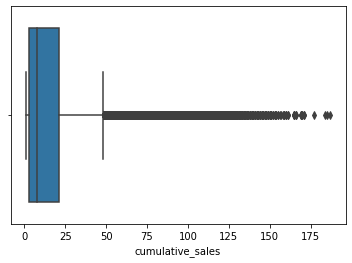

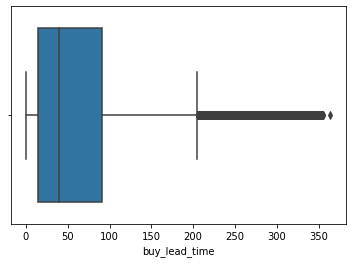

In [ ]:
cols=['num_seats_total', 'mean_net_ticket_price', 'cumulative_sales', 'buy_lead_time']
for i in cols:
    sns.boxplot(x=df[i])
    plt.show()

In [ ]:
#  Outlier capping 

cols=['num_seats_total', 'mean_net_ticket_price', 'cumulative_sales','buy_lead_time']
stats=df[cols].describe()

# Integrate caps to stats table

l_p95=[]
l_p10=[]
up_capped=[]
low_capped=[]


for i in stats.columns:
    l_p95.append(np.percentile(df[i],95))
    l_p10.append(np.percentile(df[i],10))

capping=pd.DataFrame(list(zip(cols,l_p10,l_p95)))
capping.columns=['index','lower_cap','upper_cap']

stats=stats.transpose().reset_index()
stats=pd.merge(stats,capping,on='index',how='inner')          

for i in stats.index:
    
    col_name=stats.iloc[i,0]
    col_ucap=stats.iloc[i,10]
    col_lcap=stats.iloc[i,9]
    
    originals=df[col_name].values
    
    ucap_ctr= np.count_nonzero(originals > col_ucap)
    up_capped.append(ucap_ctr)
   
    lcap_ctr=np.count_nonzero(originals < col_lcap)
    low_capped.append(lcap_ctr)
    
cap_ctrs=pd.DataFrame(list(zip(cols,low_capped,up_capped)))
cap_ctrs.columns=['index','< lower_cap','> upper_cap']
stats=pd.merge(stats,cap_ctrs,on='index',how='inner')   
stats.set_index('index',inplace=True)
stats

,count,mean,std,min,25%,50%,75%,max,lower_cap,upper_cap,< lower_cap,> upper_cap
index,,,,,,,,,,,,
num_seats_total,209696.0,2.383026,2.083327,1.000000,1.00000,2.000000,3.000000,66.000000,1.000000,6.000000,0,9515
mean_net_ticket_price,209696.0,230.114889,147.022252,1.278969,108.87012,186.282006,350.409244,7855.766106,90.750644,513.468378,20970,10485
cumulative_sales,209696.0,15.875134,19.795698,1.000000,3.00000,8.000000,21.000000,187.000000,1.000000,58.000000,0,10290
buy_lead_time,209696.0,63.264860,65.050802,0.000000,15.00000,39.000000,91.000000,364.000000,6.000000,201.000000,19538,10351


In [ ]:
# Create copy and show capped features

x=df.copy()

seats_lcap=stats.iloc[0,8]
seats_upcap=stats.iloc[0,9]

price_lcap=stats.iloc[1,8]
price_upcap=stats.iloc[1,9]

cum_lcap=stats.iloc[2,8]
cum_upcap=stats.iloc[2,9]

lead_lcap=stats.iloc[3,8]
lead_upcap=stats.iloc[3,9]

x['c_price']=[price_upcap if i>price_upcap else i for i in df['mean_net_ticket_price']]
x['c_seats']=[seats_upcap if i>seats_upcap else i for i in df['num_seats_total']]
x['c_cum']=[cum_upcap if i>cum_upcap else i for i in df['cumulative_sales']]
x['c_lead']=[lead_upcap if i>lead_upcap else i for i in df['buy_lead_time']]

x['c_seats'].where(x['c_seats'] <= seats_lcap, seats_lcap)  
x['c_price'].where(x['c_price'] <= price_lcap, price_lcap)  
x['c_cum'].where(x['c_cum'] <= cum_lcap, cum_lcap)  
x['c_lead'].where(x['c_lead'] <= lead_lcap, lead_lcap) 

# Clean up copied df with capped values

x=x.drop(cols,axis=1)

xcols = ['c_price','c_seats','c_cum','c_lead']
cols=['mean_net_ticket_price','num_seats_total', 'cumulative_sales','buy_lead_time']

# Rename so existing code can easily be reused

x=x.rename(columns=dict(list(zip(xcols,cols))))

df=x.copy() 
df.head()

,dept_date,purchase_date,train,isnormcabin,isreturn,isoneway,customer_cat,dept_daynum,dept_monthnum,train_capacity,mean_net_ticket_price,num_seats_total,cumulative_sales,buy_lead_time
202522,2018-06-01,2018-06-01,A,0,0,0,A,5,6,6,418.084961,1.0,1.0,0.0
202514,2018-06-02,2018-06-01,A,0,0,0,B,6,6,9,464.041601,1.0,1.0,1.0
202492,2018-06-03,2018-06-01,A,0,0,0,A,7,6,11,513.468378,4.0,4.0,2.0
202495,2018-06-03,2018-06-02,A,0,0,0,A,7,6,11,513.468378,1.0,5.0,1.0
202505,2018-06-03,2018-06-03,A,0,0,1,B,7,6,11,513.468378,2.0,2.0,0.0


### 4. FINAL DATATSET FOR REGRESSION <a id="section4"></a>

In [ ]:
# Convert categorical to dummy variables
# RS: Set drop_first = True to eliminate perfect multicollinearity
df=pd.get_dummies(data=df, columns=['train', 'customer_cat','dept_daynum', 'dept_monthnum'], drop_first=True)
df.head()

,dept_date,purchase_date,isnormcabin,isreturn,isoneway,train_capacity,mean_net_ticket_price,num_seats_total,cumulative_sales,buy_lead_time,train_B,train_C,train_D,train_E,train_F,train_G,train_H,train_I,train_J,train_K,train_L,train_M,train_N,customer_cat_B,dept_daynum_2,dept_daynum_3,dept_daynum_4,dept_daynum_5,dept_daynum_6,dept_daynum_7,dept_monthnum_2,dept_monthnum_3,dept_monthnum_4,dept_monthnum_5,dept_monthnum_6,dept_monthnum_7,dept_monthnum_8,dept_monthnum_9,dept_monthnum_10,dept_monthnum_11,dept_monthnum_12
202522,2018-06-01,2018-06-01,0,0,0,6,418.084961,1.0,1.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
202514,2018-06-02,2018-06-01,0,0,0,9,464.041601,1.0,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
202492,2018-06-03,2018-06-01,0,0,0,11,513.468378,4.0,4.0,2.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
202495,2018-06-03,2018-06-02,0,0,0,11,513.468378,1.0,5.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
202505,2018-06-03,2018-06-03,0,0,1,11,513.468378,2.0,2.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0


In [ ]:
df.columns.values

array(['dept_date', 'purchase_date', 'isnormcabin', 'isreturn',
       'isoneway', 'train_capacity', 'mean_net_ticket_price',
       'num_seats_total', 'cumulative_sales', 'buy_lead_time', 'train_B',
       'train_C', 'train_D', 'train_E', 'train_F', 'train_G', 'train_H',
       'train_I', 'train_J', 'train_K', 'train_L', 'train_M', 'train_N',
       'customer_cat_B', 'dept_daynum_2', 'dept_daynum_3',
       'dept_daynum_4', 'dept_daynum_5', 'dept_daynum_6', 'dept_daynum_7',
       'dept_monthnum_2', 'dept_monthnum_3', 'dept_monthnum_4',
       'dept_monthnum_5', 'dept_monthnum_6', 'dept_monthnum_7',
       'dept_monthnum_8', 'dept_monthnum_9', 'dept_monthnum_10',
       'dept_monthnum_11', 'dept_monthnum_12'], dtype=object)

### 5. Addressing Endogeneity of Price in Demand Model<a id="section5"></a>

#### 5a) Structural Model OLS<a id="section5a"></a>

Structural Model: seats ~ price + train + customer_cat + day + month + isnormcabin + isoneway+ constant

In [ ]:
y = df['num_seats_total']
x = df.drop(['num_seats_total', 'cumulative_sales', 'buy_lead_time', 
             'dept_date', 'purchase_date', 'isreturn', 'train_capacity'],axis=1)
x = sm.add_constant(x)

sm_ols = IV2SLS(y, x, None, None).fit(cov_type="unadjusted")

print(sm_ols)

                            OLS Estimation Summary                            
Dep. Variable:        num_seats_total   R-squared:                      0.1178
Estimator:                        OLS   Adj. R-squared:                 0.1176
No. Observations:              209696   F-statistic:                   2.8e+04
Date:                Sun, Sep 26 2021   P-value (F-stat)                0.0000
Time:                        13:25:12   Distribution:                 chi2(34)
Cov. Estimator:            unadjusted                                         
                                                                              
                                   Parameter Estimates                                   
                       Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-----------------------------------------------------------------------------------------
const                     1.7829     0.0240     74.255     0.0000      1.7359      1.8300
isnormca

#### 5b) Reduced Form of Price<a id="section5b"></a>

Reduced Form: price ~ (all structural) + isreturn + buy_lead_time


In [ ]:
y_price = df['mean_net_ticket_price']
x_price = df.drop(['num_seats_total','cumulative_sales','dept_date', 'purchase_date',
                   'train_capacity', 'mean_net_ticket_price'],axis=1)
x_price = sm.add_constant(x_price)

rf_ols = IV2SLS(y_price, x_price, None, None).fit(cov_type="unadjusted")

print(rf_ols)

                              OLS Estimation Summary                             
Dep. Variable:     mean_net_ticket_price   R-squared:                      0.6705
Estimator:                           OLS   Adj. R-squared:                 0.6704
No. Observations:                 209696   F-statistic:                 4.266e+05
Date:                   Sun, Sep 26 2021   P-value (F-stat)                0.0000
Time:                           13:25:17   Distribution:                 chi2(35)
Cov. Estimator:               unadjusted                                         
                                                                                 
                                Parameter Estimates                                 
                  Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------------
const                384.10     1.0424     368.48     0.0000      382.06      386.14
isno

#### 5c) 2SLS of Structual Model <a id="section5c"></a>

In [ ]:
exo = df.drop(['num_seats_total', 'mean_net_ticket_price','cumulative_sales', 'buy_lead_time', 
             'dept_date', 'purchase_date', 'isreturn', 'train_capacity'],axis=1)

exo = sm.add_constant(exo)

endo = df[['mean_net_ticket_price']]

iv = df[['isreturn','buy_lead_time']]

sm_2sls = IV2SLS(y, exo, endo, iv).fit(
    cov_type="unadjusted"
)

print(sm_2sls)

                          IV-2SLS Estimation Summary                          
Dep. Variable:        num_seats_total   R-squared:                      0.0918
Estimator:                    IV-2SLS   Adj. R-squared:                 0.0917
No. Observations:              209696   F-statistic:                 2.805e+04
Date:                Sun, Sep 26 2021   P-value (F-stat)                0.0000
Time:                        13:25:21   Distribution:                 chi2(34)
Cov. Estimator:            unadjusted                                         
                                                                              
                                   Parameter Estimates                                   
                       Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-----------------------------------------------------------------------------------------
const                     2.8779     0.0399     72.061     0.0000      2.7997      2.9562
isnormca

#### 5d) Hausman Test for Endogeneity <a id="section5d"></a>

P-value ~ 0.00, hence reject H0 that endogenous variables are exogenous. This confirms that price is endogenous.

In [ ]:
sm_2sls.wu_hausman()

Wu-Hausman test of exogeneity
H0: All endogenous variables are exogenous
Statistic: 1239.5352
P-value: 0.0000
Distributed: F(1,209660)
WaldTestStatistic, id: 0x7fe0d17abdd0

#### 5e) Sargan Test for Overidentification <a id="section5e"></a>

In [ ]:
sm_2sls.wooldridge_overid

Wooldridge's score test of overidentification
H0: Model is not overidentified.
Statistic: 0.0167
P-value: 0.8972
Distributed: chi2(1)
WaldTestStatistic, id: 0x7fe0cf66f190

### 6) Final 2SLS Demand Model <a id="section6"></a>

In [ ]:
print(compare({"OLS": sm_ols, "2SLS": sm_2sls}))

                         Model Comparison                        
                                          OLS                2SLS
-----------------------------------------------------------------
Dep. Variable                 num_seats_total     num_seats_total
Estimator                                 OLS             IV-2SLS
No. Observations                       209696              209696
Cov. Est.                          unadjusted          unadjusted
R-squared                              0.1178              0.0918
Adj. R-squared                         0.1176              0.0917
F-statistic                           2.8e+04           2.805e+04
P-value (F-stat)                       0.0000              0.0000
=======================     =================   =================
const                                  1.7829              2.8779
                                     (74.255)            (72.061)
isnormcabin                            0.0139             -0.4917
          

Mean of residuals: -1.5013501446349085e-14


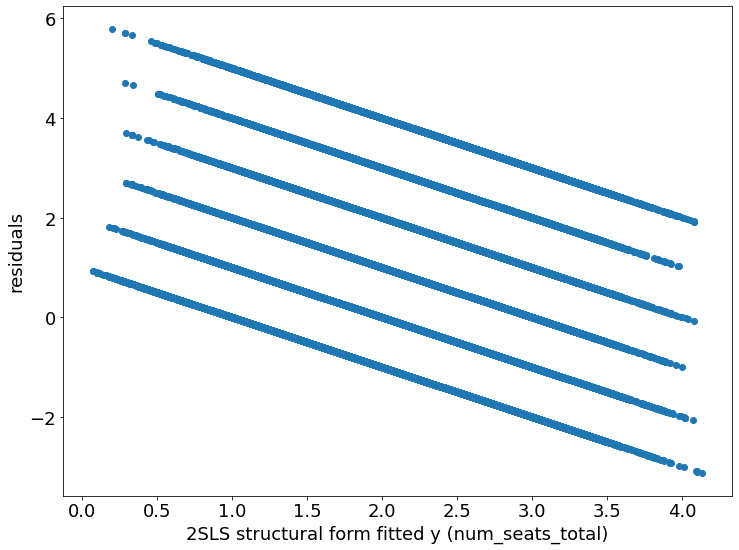

In [ ]:
#Plot residuals of final model

plot_x = sm_2sls.predict()
plot_y = sm_2sls.resids

fig, ax1 = plt.subplots(figsize=(12, 9))
plt.tick_params(labelsize=18)

plt.xlabel("2SLS structural form fitted y (num_seats_total)", fontsize=18)
plt.ylabel("residuals", fontsize=18)

plt.scatter(plot_x, plot_y)

print("Mean of residuals: "+str(plot_y.mean()))